<a href="https://colab.research.google.com/github/Caterinasacco/Semantic-Segmentation-/blob/main/Segmentaz_pareti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Caricamento del dataset da kaggle


In [ ]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"caterinasacco","key":"2e306986162f193005572f88b3bf7ac5"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d balraj98/facades-dataset


Dataset URL: https://www.kaggle.com/datasets/balraj98/facades-dataset
License(s): other
 98% 33.0M/33.5M [00:01<00:00, 34.3MB/s]
100% 33.5M/33.5M [00:01<00:00, 23.2MB/s]


In [ ]:
!unzip facades-dataset.zip -d /content/dataset


# Preprocesing e split train e test

In [ ]:
import tensorflow as tf

train_image = "/content/dataset/trainA"
train_mask = "/content/dataset/trainB"
test_image = "/content/dataset/testA"
test_mask = "/content/dataset/testB"


def preprocess_image(image):
    image = tf.image.resize(image, (160, 160))
    image = image / 255.0
    return image

def preprocess_mask(mask):
    mask = tf.image.resize(mask, (160, 160))
    mask = tf.image.rgb_to_grayscale(mask)  # Scala di grigi
    mask = tf.squeeze(mask, axis=-1)        # Rimuoviamo l'ultimo asse
    mask = tf.cast(mask // 25, tf.uint8)    # Normalizziamo
    mask = tf.expand_dims(mask, axis=-1)    # Aggiungiamo un asse per il canale
    return mask

train_images = tf.keras.utils.image_dataset_from_directory(
    train_image,
    image_size=(160, 160),
    batch_size=None,
    shuffle=False,
    label_mode=None
).map(preprocess_image)

test_images = tf.keras.utils.image_dataset_from_directory(
    test_image,
    image_size=(160, 160),
    batch_size=None,
    shuffle=False,
    label_mode=None
).map(preprocess_image)

train_masks = tf.keras.utils.image_dataset_from_directory(
    train_mask,
    image_size=(160, 160),
    batch_size=None,
    shuffle=False,
    label_mode=None
).map(preprocess_mask)

test_masks = tf.keras.utils.image_dataset_from_directory(
    test_mask,
    image_size=(160, 160),
    batch_size=None,
    shuffle=False,
    label_mode=None
).map(preprocess_mask)

train_dataset = tf.data.Dataset.zip((train_images, train_masks))
test_dataset = tf.data.Dataset.zip((test_images, test_masks))

def filter_valid_shapes(image, mask):
    return tf.equal(tf.shape(image), tf.shape(mask))

train_dataset = train_dataset.filter(
    lambda img, mask: tf.reduce_all(tf.shape(img) == [160, 160, 3]) and tf.reduce_all(tf.shape(mask) == [160, 160, 1])
)
test_dataset = test_dataset.filter(
    lambda img, mask: tf.reduce_all(tf.shape(img) == [160, 160, 3]) and tf.reduce_all(tf.shape(mask) == [160, 160, 1])
)

train_dataset = train_dataset.shuffle(buffer_size=1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

for img, mask in train_dataset.take(1):
    print(f"Forma delle immagini: {img.shape}")
    print(f"Forma delle maschere: {mask.shape}")


Found 400 files.
Found 106 files.
Found 400 files.
Found 106 files.
Forma delle immagini: (32, 160, 160, 3)
Forma delle maschere: (32, 160, 160, 1)


#U-net


In [ ]:
def data_augmentation(img, mask):
    # Flip orizzontale
    img = tf.image.random_flip_left_right(img)
    mask = tf.image.random_flip_left_right(mask)
    # Rotazione
    img = tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    mask = tf.image.rot90(mask, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Luminosità
    img = tf.image.random_brightness(img, 0.2)
    return img, mask

train_dataset = train_dataset.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)


In [ ]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, ReLU, MaxPooling2D, Concatenate, Input
from tensorflow.keras import models
from tensorflow.keras.layers import Dropout

def convolution_operation(entered_input, filters=64):
    conv1 = Conv2D(filters, kernel_size=(3, 3), padding='same')(entered_input)
    batch_norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(batch_norm1)
    drop1 = Dropout(0.3)(act1)

    conv2 = Conv2D(filters, kernel_size=(3, 3), padding='same')(drop1)
    batch_norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(batch_norm2)
    drop2 = Dropout(0.3)(act2)

    return drop2

def encoder(entered_input, filters=64):
    enc1 = convolution_operation(entered_input, filters)
    MaxPool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(enc1)
    return enc1, MaxPool1


def decoder(entered_input, skip, filters=64):
    Upsample = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(entered_input)
    Connect_Skip = Concatenate()([Upsample, skip])
    out = convolution_operation(Connect_Skip, filters)
    out = Dropout(0.3)(out)  # Aggiunto dropout
    return out

def U_Net(Image_Size=(160, 160, 3), num_classes=10):
    input1 = Input(shape=Image_Size)

    skip1, encoder_1 = encoder(input1, 32)
    skip2, encoder_2 = encoder(encoder_1, 64)
    skip3, encoder_3 = encoder(encoder_2, 64*2)
    skip4, encoder_4 = encoder(encoder_3, 64*4)

    # Bottleneck
    conv_block = convolution_operation(encoder_4, 64*16)

    # Decoder
    decoder_1 = decoder(conv_block, skip4, 64*4)
    decoder_2 = decoder(decoder_1, skip3, 64*2)
    decoder_3 = decoder(decoder_2, skip2, 64)
    decoder_4 = decoder(decoder_3, skip1, 32)

    # Strato finale per 10 classi
    out = Conv2D(num_classes, 1, padding="same")(decoder_4)

    model = models.Model(inputs=input1, outputs=out)
    return model


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]


In [ ]:
# Calcola i pesi delle classi
total_samples = np.sum(class_distribution.numpy())
class_frequencies = class_distribution.numpy()
class_weights = {i: total_samples / (class_frequencies[i] + 1e-6) for i in range(10)}

print("Pesi delle classi:", class_weights)


Pesi delle classi: {0: 66.63087859656572, 1: 5.498215361977815, 2: 2.430646319893342, 3: 19.41784393661843, 4: 5.589881986069246, 5: 47.617663641846704, 6: 27.806724257810266, 7: 23.615555363303596, 8: 16.284210358888163, 9: 1693.2616780295034}


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=150,
    #class_weight=class_weights,
    #callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 874ms/step - accuracy: 0.6671 - loss: 1.0383 - mean_iou_custom: 0.2417 - val_accuracy: 0.4561 - val_loss: 1.8851 - val_mean_iou_custom: 0.0987
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 870ms/step - accuracy: 0.6701 - loss: 1.0359 - mean_iou_custom: 0.2402 - val_accuracy: 0.5644 - val_loss: 1.4224 - val_mean_iou_custom: 0.1562
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 823ms/step - accuracy: 0.6676 - loss: 1.0399 - mean_iou_custom: 0.2415 - val_accuracy: 0.5554 - val_loss: 1.4648 - val_mean_iou_custom: 0.1525
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 828ms/step - accuracy: 0.6734 - loss: 1.0243 - mean_iou_custom: 0.2438 - val_accuracy: 0.5271 - val_loss: 1.5882 - val_mean_iou_custom: 0.1441
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 837ms/step - accuracy: 0.6783 - loss: 1.0094 - mean_iou_custom: 0.2496 - val_accuracy: 0.5646 - val_loss: 1.3553 - val_mean_iou_custom: 0.1541
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 809ms/step - accuracy: 0.68

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


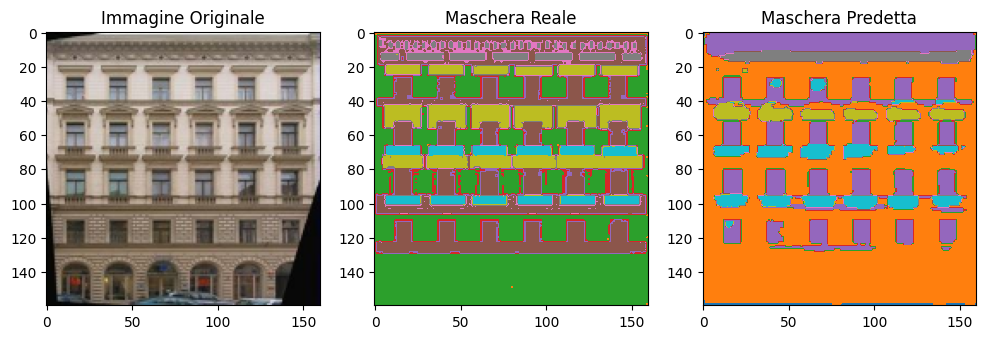

In [ ]:
import matplotlib.pyplot as plt

for img, mask in test_dataset.take(1):
    predictions = model.predict(img)
    predicted_classes = tf.argmax(predictions, axis=-1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Immagine Originale")
    plt.imshow(img[1].numpy())

    plt.subplot(1, 3, 2)
    plt.title("Maschera Reale")
    plt.imshow(mask[1].numpy().squeeze(), cmap='tab10')

    plt.subplot(1, 3, 3)
    plt.title("Maschera Predetta")
    plt.imshow(predicted_classes[1].numpy(), cmap='tab10')

    plt.show()


#Addestramento modello

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


inputs = layers.Input(shape=(160, 160, 3))

# Encoder
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
p1 = layers.MaxPooling2D((2, 2))(c1)

c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
p2 = layers.MaxPooling2D((2, 2))(c2)

# Bottleneck
b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
b1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(b1)

# Decoder
u1 = layers.UpSampling2D((2, 2))(b1)
u1 = layers.Concatenate()([u1, c2])
c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

u2 = layers.UpSampling2D((2, 2))(c3)
u2 = layers.Concatenate()([u2, c1])
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

outputs = layers.Conv2D(10, (1, 1), activation='softmax')(c4)

model = models.Model(inputs, outputs)
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
]
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=500,
    batch_size=16,
    callbacks=callbacks
)


Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 685ms/step - accuracy: 0.2353 - loss: 2.2863 - val_accuracy: 0.4096 - val_loss: 1.8672 - learning_rate: 0.0010
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 381ms/step - accuracy: 0.4134 - loss: 1.8159 - val_accuracy: 0.4096 - val_loss: 1.7453 - learning_rate: 0.0010
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 378ms/step - accuracy: 0.4120 - loss: 1.7396 - val_accuracy: 0.4096 - val_loss: 1.6931 - learning_rate: 0.0010
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 379ms/step - accuracy: 0.4136 - loss: 1.6956 - val_accuracy: 0.4158 - val_loss: 1.6509 - learning_rate: 0.0010
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 380ms/step - accuracy: 0.4310 - loss: 1.6431 - val_accuracy: 0.4351 - val_loss: 1.6193 - learning_rate: 0.0010
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 397ms/step - accuracy: 0.4455 - loss: 1.6099 - val_accuracy: 0.4167 - val_loss: 1.6467 - learning_rate: 0.0010
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 386ms/step - accuracy: 0.4439 - loss

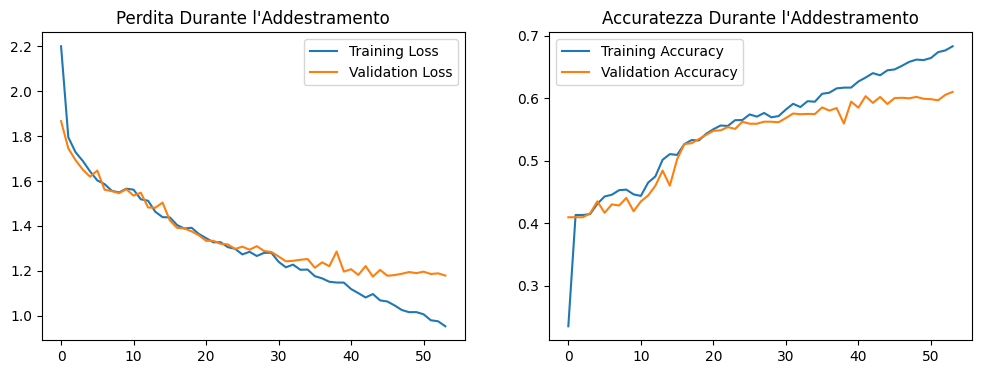

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Perdita Durante l\'Addestramento')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuratezza Durante l\'Addestramento')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step


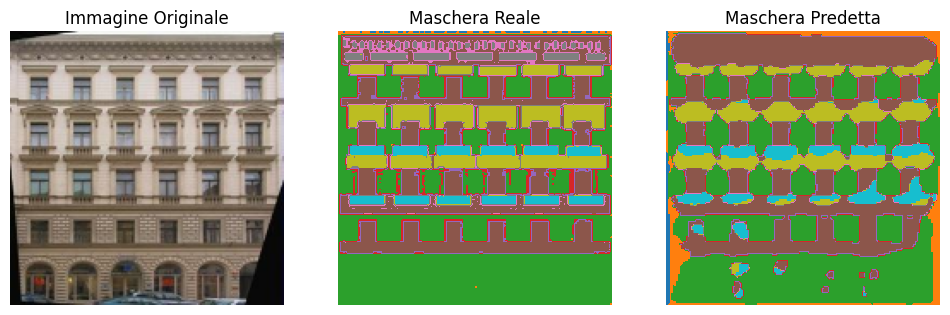

In [ ]:
for img, mask in test_dataset.take(1):
    predictions = model.predict(img)
    pred_mask = tf.argmax(predictions, axis=-1)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.imshow(img[1].numpy())
    plt.title("Immagine Originale")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask[1].numpy(), cmap='tab10')
    plt.title("Maschera Reale")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask[1].numpy(), cmap='tab10')
    plt.title("Maschera Predetta")
    plt.axis("off")

    plt.show()


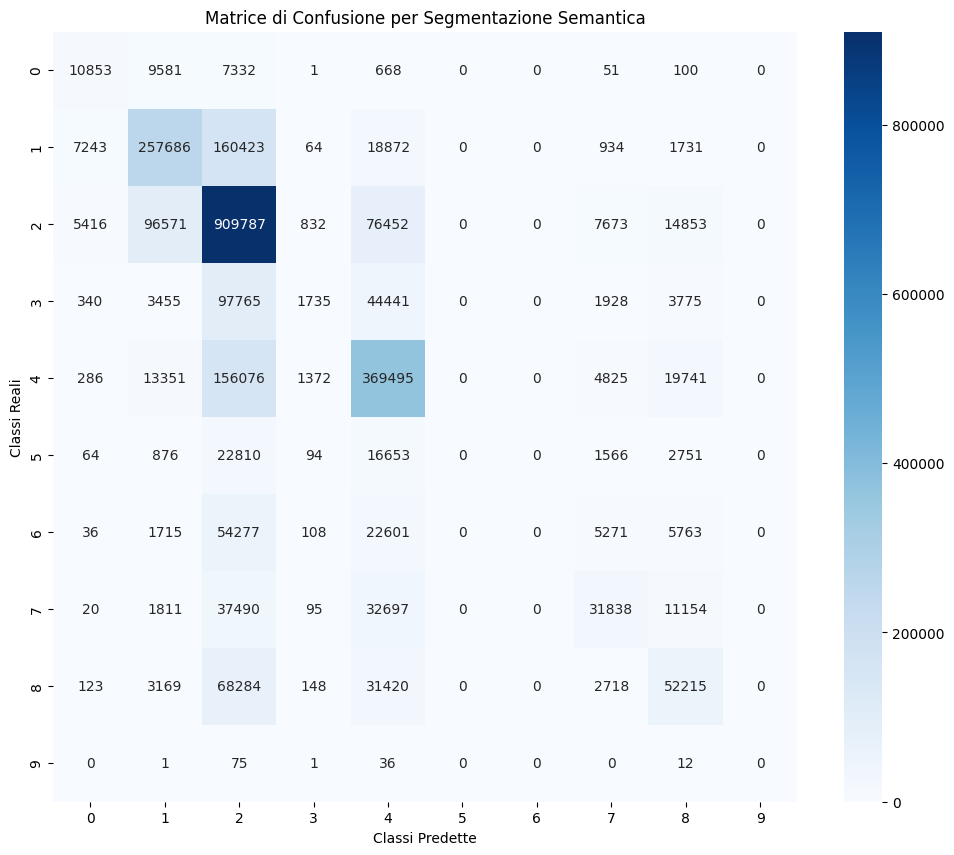

In [ ]:
# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_masks, pred_masks, labels=np.arange(num_classes))

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))
plt.xlabel('Classi Predette')
plt.ylabel('Classi Reali')
plt.title('Matrice di Confusione per Segmentazione Semantica')
plt.show()
